In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 100)
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [27]:
df_ta_BTC = pd.read_csv('../Crypto_data/BITCOIN_Data.csv')
df_ta_SHIB = pd.read_csv('../Crypto_data/SHIBAINU_Data.csv')
df_ta_SOL = pd.read_csv('../Crypto_data/SOLANA_Data.csv')
df_ta_ETH = pd.read_csv('../Crypto_data/ETHEREUM_Data.csv')
df_ta_LINK = pd.read_csv('../Crypto_data/CHAINLINK_Data.csv')
df_ta_DOGE = pd.read_csv('../Crypto_data/DOGECOIN_Data.csv')

In [28]:
df_ta_BTC

,Datum,Zuletzt,Eröffn.,Hoch,Tief,Vol.,+/- %
0,08.12.2021,"50.497,1","50.596,6","50.799,1","50.090,9","48,86K","-0,19%"
1,07.12.2021,"50.595,2","50.547,4","51.918,6","50.070,9","56,29K","0,07%"
2,06.12.2021,"50.562,1","49.412,1","50.913,3","47.237,9","89,68K","2,34%"
3,05.12.2021,"49.405,5","49.196,4","49.689,3","47.797,8","72,03K","0,43%"
4,04.12.2021,"49.195,2","53.620,7","53.847,2","42.587,8","168,00K","-8,27%"
...,...,...,...,...,...,...,...
703,05.01.2020,"7.372,5","7.376,8","7.501,0","7.345,6","628,14K","-0,06%"
704,04.01.2020,"7.376,8","7.345,1","7.433,1","7.291,4","523,91K","0,46%"
705,03.01.2020,"7.343,1","6.967,1","7.402,9","6.884,1","936,29K","5,40%"
706,02.01.2020,"6.967,0","7.199,7","7.209,6","6.901,4","632,78K","-3,23%"


In [29]:
df_ta_ETH

,Datum,Zuletzt,Eröffn.,Hoch,Tief,Vol.,+/- %
0,08.12.2021,"4.375,00","4.308,26","4.383,50","4.282,34","377,89K","1,58%"
1,07.12.2021,"4.307,11","4.350,79","4.424,22","4.259,06","420,89K","-1,05%"
2,06.12.2021,"4.352,66","4.197,06","4.374,22","3.922,04","726,73K","3,77%"
3,05.12.2021,"4.194,60","4.123,56","4.247,57","4.035,80","536,33K","1,86%"
4,04.12.2021,"4.118,06","4.213,57","4.237,33","3.561,06","1,11M","-2,36%"
...,...,...,...,...,...,...,...
698,05.01.2020,"135,42","134,19","138,15","134,19","509,94K","0,93%"
699,04.01.2020,"134,17","134,41","135,76","132,47","368,13K","-0,14%"
700,03.01.2020,"134,37","127,07","134,95","125,97","672,31K","5,74%"
701,02.01.2020,"127,07","130,68","130,74","126,58","307,51K","-2,79%"


In [ ]:
x = df_ta_ETH['Date']
y1 = df_backup_cut['Prediction']
y2 = df_backup_cut['Actual']

fig, ax = plt.subplots(figsize=(14,5))

curr = 'ETH'

ax.plot(x,y2, color = 'red', label = 'Real '+ curr + ' Price')
ax.plot(x,y1, color = 'green', label = 'Predicted '+ curr + ' Price')

ax.set_title('Bitcoin Price Prediction using RNN-LSTM')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.legend()
ax.grid()

plt.show()

In [15]:
def preprocessing(data):
    data.rename(columns={'Datum':'Date', 'Eröffn.':'Open', 'Hoch':'High',
                     'Tief':'Low', 'Vol.':'Volume', 'Zuletzt':'Close'}, inplace=True)
    data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')
    data.drop('+/- %', axis=1, inplace=True)
    data.sort_values('Date', inplace=True)
    data.reset_index(drop=True, inplace=True)

    
    for column in data.drop(columns=['Date', 'Volume']).columns:
        data[column] = [float(str(i).replace(",", "")) for i in data[column]]
        
    data['Volume'] = [str(i).replace(",", "") for i in data['Volume']]
    data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    

    def value_to_float(x):
        if type(x) == float or type(x) == int:
            return x
        if 'K' in x:
            if len(x) > 1:
                return float(x.replace('K', '')) * 1000
            return 1000.0
        if 'M' in x:
            if len(x) > 1:
                return float(x.replace('M', '')) * 1000000
            return 1000000.0
        if 'B' in x:
            return float(x.replace('B', '')) * 1000000000
        return 0.0

    data['Volume'] = data['Volume'].apply(value_to_float)
    data['Volume'] = data['Volume'] / 1000.0

    
    data_training = data[data['Date'] < '2021-06-01'].copy()
    data_test = data[data['Date'] > '2021-06-01'].copy()
    
    training_data = data_training.drop(['Date'], axis = 1)
    
    # MinMaxScaler is used to normalize the data
    scaler = MinMaxScaler()
    training_data = scaler.fit_transform(training_data)
    training_data
    
    X_train = [] 
    Y_train = []
    
    for i in range(60, training_data.shape[0]):
        X_train.append(training_data[i-60:i])   
        Y_train.append(training_data[i,0])
    
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    
    return data_test, data_training, data, X_train, Y_train, scaler

In [16]:
def training(X_train, Y_train):
    #Initialize the RNN
    model = Sequential() 
    model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], len(X_train[0][0]))))
    model.add(Dropout(0.2)) 
    model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.3)) 
    model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.4)) 
    model.add(LSTM(units = 120, activation = 'relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(units =1))
    model.summary()
    
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    history = model.fit(X_train, Y_train, epochs = 20, batch_size = 50, 
                        validation_split = 0.1)
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()
    
    return model

In [20]:
def prediction(model, data_training, data_test, scaler, curr):
    part_60_days = data_training.tail(60)
    df = part_60_days.append(data_test, ignore_index = True)
    df_backup = df.copy()
    df = df.drop(['Date'], axis = 1)
    df.head()
    
    inputs = scaler.transform(df)
    
    X_test = []
    Y_test = []
    
    for i in range (60, inputs.shape[0]):
        X_test.append(inputs[i-60:i])
        Y_test.append(inputs[i, 0])

    X_test, Y_test = np.array(X_test), np.array(Y_test) 
    
    Y_pred = model.predict(X_test)
    
    scale = 1/scaler.scale_[0]
    Y_test = Y_test*scale
    Y_pred = Y_pred*scale
    
    df_backup_cut = df_backup[-190:]
    df_backup_cut['Prediction'] = Y_pred
    df_backup_cut['Actual'] = Y_test
    
    y1 = df_backup_cut['Prediction']
    y2 = df_backup_cut['Actual']

    x = df_backup_cut['Date']
    y1 = df_backup_cut['Prediction']
    y2 = df_backup_cut['Actual']
    
    fig, ax = plt.subplots(figsize=(14,5))

    ax.plot(x,y2, color = 'red', label = 'Real '+ curr + ' Price')
    ax.plot(x,y1, color = 'green', label = 'Predicted '+ curr + ' Price')

    ax.set_title('Bitcoin Price Prediction using RNN-LSTM')
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid()

    plt.show()
    
    return df_backup_cut

In [21]:
def full_prediction_workflow(data, curr):
    data_test, data_training, data, X_train, Y_train, scaler = preprocessing(data)
    model = training(X_train, Y_train)
    df_backup_cut = prediction(model, data_training, data_test, scaler, curr)
    
    return df_backup_cut

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 50)            11200     
                                                                 
 dropout_8 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_9 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 80)            45120     
                                                                 
 dropout_10 (Dropout)        (None, 60, 80)            0         
                                                                 
 lstm_11 (LSTM)              (None, 120)              

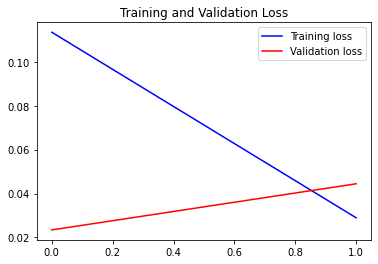

C:\Users\Christian\AppData\Local\Temp\ipykernel_15084\1526734230.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backup_cut['Prediction'] = Y_pred
C:\Users\Christian\AppData\Local\Temp\ipykernel_15084\1526734230.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backup_cut['Actual'] = Y_test


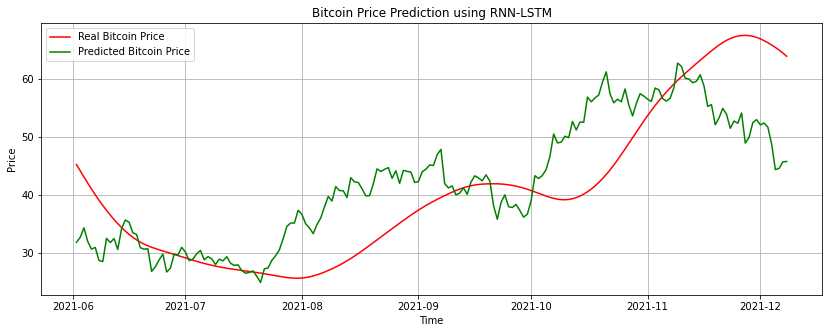

,Date,Open,High,Low,Close,Volume,Prediction,Actual
60,2021-06-02,36.6877,38.1999,35.9811,37.5558,9689.0,45.265800,31.8725
61,2021-06-03,37.5557,39.4623,37.1936,39.1873,10644.0,44.184090,32.7405
62,2021-06-04,39.1914,39.2554,35.6599,36.8513,12771.0,43.111565,34.3762
63,2021-06-05,36.8412,37.8876,34.8320,35.5200,10148.0,42.061977,32.0260
64,2021-06-06,35.5187,36.4340,35.2653,35.8154,6220.0,41.042965,30.7035
...,...,...,...,...,...,...,...,...
245,2021-12-04,53.6207,53.8472,42.5878,49.1952,16800.0,65.821320,48.8055
246,2021-12-05,49.1964,49.6893,47.7978,49.4055,7203.0,65.397629,44.3812
247,2021-12-06,49.4121,50.9133,47.2379,50.5621,8968.0,64.934479,44.5969
248,2021-12-07,50.5474,51.9186,50.0709,50.5952,5629.0,64.427292,45.7322


In [43]:
full_prediction_workflow(da_ta_BTC, 'Bitcoin')

In [57]:
full_prediction_workflow(df_ta_SHIB)

IndexError: tuple index out of range

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 50)            11200     
                                                                 
 dropout_8 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_9 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 80)            45120     
                                                                 
 dropout_10 (Dropout)        (None, 60, 80)            0         
                                                                 
 lstm_11 (LSTM)              (None, 120)              

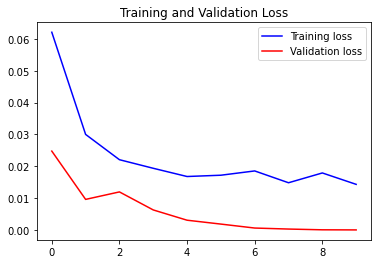

C:\Users\Christian\AppData\Local\Temp\ipykernel_17540\1033521564.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backup_cut['Prediction'] = Y_pred
C:\Users\Christian\AppData\Local\Temp\ipykernel_17540\1033521564.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_backup_cut['Actual'] = Y_test


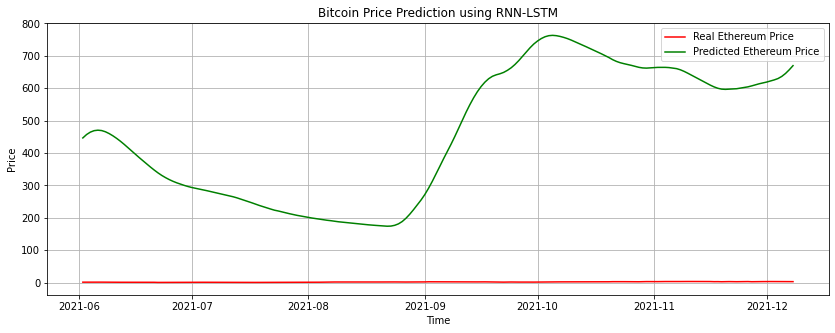

,Date,Open,High,Low,Close,Volume,Prediction,Actual
60,2021-06-02,2.63379,2.70619,2.63379,2.70619,8546.0,446.779266,1.62320
61,2021-06-03,2.70524,2.85664,2.70466,2.85664,7174.0,457.300476,1.69465
62,2021-06-04,2.85702,2.85702,2.63818,2.68705,10986.0,464.732544,1.84643
63,2021-06-05,2.68837,2.74288,2.62222,2.62885,8678.0,469.221893,1.67778
64,2021-06-06,2.62813,2.71242,2.62813,2.71242,5298.0,470.696594,1.61754
...,...,...,...,...,...,...,...,...
245,2021-12-04,4.21357,4.23733,3.56106,4.11806,111000.0,630.045105,3.20298
246,2021-12-05,4.12356,4.24757,4.03580,4.19460,53633.0,636.570801,3.11297
247,2021-12-06,4.19706,4.37422,3.92204,4.35266,72673.0,645.680847,3.18647
248,2021-12-07,4.35079,4.42422,4.25906,4.30711,42089.0,657.117554,3.34020


In [24]:
full_prediction_workflow(df_ta_ETH, 'Ethereum')

In [ ]:
full_prediction_workflow(df_ta_LINK)

In [ ]:
full_prediction_workflow(df_ta_DOGE)

In [ ]:
full_prediction_workflow(df_ta_SOL)